## SQLAlchemy

### What is it?

   * **Object-Relational Mapper** -- A technique that connects the objects of an application to tables in an RDB
   * **multi-level** -- can interact with DBs as multiple levels of abstraction

### Why is it useful?

[There are some reasons you should consider SQLAlchemy](http://danielweitzenfeld.github.io/passtheroc/blog/2014/10/12/datasci-sqlalchemy)

   * Uses less database specific code
   * Generalizes easily to different databases
   * Integrates nicely with [Django](https://www.djangoproject.com), [Pylons/Pyrmaid](http://www.pylonsproject.org/) and [Flask](http://flask.pocoo.org)

There are also a [few organizations you may have heard of](http://www.sqlalchemy.org/organizations.html) that use SQLAlchemy.

### Database setup

On OSX use only second command

```bash
$ sudo su - postgres
$ psql -U postgres
```

Then

```sql
CREATE USER ender WITH ENCRYPTED PASSWORD 'bugger';
CREATE DATABASE foo WITH OWNER ender;
\q
```

### Create a DB

In [2]:
import os,sys,getpass,datetime
from sqlalchemy import Column, ForeignKey, Integer, String, Float, DateTime
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

Base = declarative_base()


class Member(Base):
    __tablename__ = 'member'
    id = Column(Integer, primary_key=True)
    name = Column(String(250), nullable=False)
    address = Column(String(250), nullable=False)
    signup_store = Column(String(250))

class Purchase(Base):
    __tablename__ = 'purchase'
    id = Column(Integer, primary_key=True)
    item_number = Column(Integer, nullable=False)
    item_category = Column(String(250), nullable=False)
    item_name = Column(String(250), nullable=False)
    item_amount = Column(Float, nullable=False)
    purchace_date = Column(DateTime,default=datetime.datetime.utcnow)
    member_id = Column(Integer, ForeignKey('member.id'))
    member = relationship(Member)        
        
class Game(Base):
    __tablename__ = 'game'
    id = Column(Integer, primary_key=True)
    game_name = Column(String(250))
    game_type = Column(String(250))
    game_maker = Column(String(250), nullable=False)
    game_date = Column(DateTime, default=datetime.datetime.utcnow)
    member_id = Column(Integer, ForeignKey('member.id'))
    member = relationship(Member)        

## Create an engine
uname = 'ender'
upass = getpass.getpass()
dbname = 'foo'
dbhost = 'localhost'
port = '5432'
engine = create_engine('postgresql://%s:%s@%s:%s/%s'%(uname,upass,dbhost,port,dbname))

## erase the taples if they exist (CAREFUL the drop_all!!!)
Base.metadata.reflect(bind=engine)
Base.metadata.drop_all(engine)

## Create all tables in the engine. This is equivalent to "Create Table"
Base.metadata.create_all(engine)

········


### Add some content to the DB

In [4]:
## create a session (staging zone)
Base.metadata.bind = engine
DBSession = sessionmaker(bind=engine)
session = DBSession()

## add some members
new_member_1 = Member(name='pipin',address='west shire',signup_store='prancing pony')
new_member_2 = Member(name='peregrin',address='south shire',signup_store='prancing pony')

session.add(new_member_1)
session.add(new_member_2)
session.commit()

## add some purchases
new_purchase = Purchase(item_number=1234,
                        item_category='role playing',
                        item_name='playing mat',
                        item_amount = 10.45,
                        purchace_date = datetime.datetime.utcnow,                        
                        member_id = new_member_1.id
)

session.commit()
print('done')

done


### A DbWrapper for your convenience

In [5]:
import sys,os,csv,re
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine
from sqlalchemy.orm import Session,relationship
from sqlalchemy import MetaData,Table,Column,Sequence,ForeignKey, Integer, String
from sqlalchemy.inspection import inspect
from sqlalchemy.sql import select
from sqlalchemy.ext.declarative import declarative_base

try:
    from sqlalchemy_schemadisplay import create_schema_graph
    createGraph = True
except:
    createGraph = False

class DbWrapper(object):
    """
    interface with a generic database
    """

    def __init__(self,uname,upass,dbname,dbhost='localhost',port='5432',reflect=False):
        """
        Constructor

        uname - database username
        upass - database password
        dbname - database name
        dbhost - database host address
        port - database port
        """

        ## db variables
        self.uname = uname
        self.upass = upass
        self.dbname = dbname
        self.dbhost = dbhost
        self.port = port

        ## initialize
        self.connect()

    def connect(self):
        ## basic connection
        self.Base = automap_base()    
        self.engine = create_engine('postgresql://%s:%s@%s:%s/%s'%(self.uname,self.upass,self.dbhost,self.port,self.dbname))
        self.conn = self.engine.connect()
        self.session = Session(self.engine)
        self.meta = MetaData()
        self.tables = {}
        
        ## reflect the tables 
        self.meta.reflect(bind=self.engine)
        for tname in self.engine.table_names():
            tbl = Table(tname,self.meta,autoload=True,autoload_with=self.engine)
            self.tables[tname] = tbl
            
    def print_summary(self):
        """
        print a list of the tables
        """

        print("-----------------------")
        print("%s"%(self.dbname))
        print("%s tables"%len(self.tables.keys()))
        
        for tname,tbl in self.tables.iteritems():
            print("\t %s"%(tname)) 
            print("\t\tPK: %s "%";".join([key.name for key in inspect(tbl).primary_key]))
            for col in tbl.columns:
                print("\t\t%s"%col)

    def draw_schema(self,filename="schema.png"):
        
        if createGraph:
            # create the pydot graph object by autoloading all tables via a bound metadata object
            graph = create_schema_graph(metadata=self.meta,
                                        show_datatypes=False,   # can get large with datatypes
                                        show_indexes=False,     # ditto for indexes
                                        rankdir='LRA',           # From left to right (LR), top to bottom (TB)
                                        concentrate=False       # Don't try to join the relation lines together
            )

            if re.search("\.png",filename):
                graph.write_png(filename)
            elif re.search("\.svg",filename):
                graph.write_svg(filename)
            else:
                raise Exception("invalid filename specified [*.png or *.svg")
        
            print("...%s created"%filename)
        else:
            print "Not creating schema figure because 'sqlalchemy_schemadisplay' is not installed"
        

### Using DbWrapper

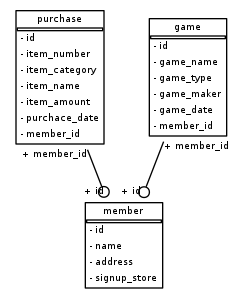

In [9]:
from IPython.display import Image
Image(filename='schema.png',width=400)

In [6]:

## connect and use the built in methods
db = DbWrapper('ender','bugger','foo')
db.print_summary()
db.draw_schema()

## sqlalchemy ORM queries
Member = db.tables['member']
all_members = db.session.query(Member).all()
specific_rows = db.session.query(Member).filter_by(name="pipin").all()

print all_members
print specific_rows
    
## sqlalchemy core queries
s = select([Member])
_result = db.conn.execute(s)
result = _result.fetchall()
print str(s)
print result[0]

-----------------------
foo
3 tables
	 member
		PK: id 
		member.id
		member.name
		member.address
		member.signup_store
	 purchase
		PK: id 
		purchase.id
		purchase.item_number
		purchase.item_category
		purchase.item_name
		purchase.item_amount
		purchase.purchace_date
		purchase.member_id
	 game
		PK: id 
		game.id
		game.game_name
		game.game_type
		game.game_maker
		game.game_date
		game.member_id
Not creating schema figure because 'sqlalchemy_schemadisplay' is not installed
[(1, u'pipin', u'west shire', u'prancing pony'), (2, u'peregrin', u'south shire', u'prancing pony'), (3, u'pipin', u'west shire', u'prancing pony'), (4, u'peregrin', u'south shire', u'prancing pony')]
[(1, u'pipin', u'west shire', u'prancing pony'), (3, u'pipin', u'west shire', u'prancing pony')]
SELECT member.id, member.name, member.address, member.signup_store 
FROM member
(1, u'pipin', u'west shire', u'prancing pony')


4